# bio.tools querying

## Overview

## Code

In [1]:
import sys
import json
import requests
import argparse
import yaml
import biotools_parse as bp
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt


# The call to get all bio.tools entries through the api is: https://bio.tools/api/tool/?format=json.
# Unfortunately, the response is limited to n tools. To get the whole set, the next pages must be retrieve.
# use "next" in the response to get succesive entries.
 
base_call = "https://bio.tools/api/tool/?format=json"


def make_request(URL):
    try:
        response = requests.get(URL)
    except:
        print('Could not make the request')
        return
    else:
        response = json.loads(response.text)
        return(response)

def build_url(next_page, filters):
    call_template = "https://bio.tools/api/tool/?{attributes}{next_page}&format=json"
    if next_page:
        next_page = "&%s"%next_page
    else:
        next_page = ""
    attributes = '&'.join(filters)    
    url = call_template.format(next_page=next_page, attributes=attributes)
    return(url)


def get_all_pages(filters):
    res = []
    next_page = "page=1"
    print('Starting making the requests...')
    while next_page:
        response = make_request(build_url(next_page, filters))
        print("Requesting: " + build_url(next_page, filters), end='\r')
        res = res + response["list"]
        next_page = response["next"]
        if next_page:
            next_page = next_page[1:]
    print('\nRequests finished.')
    return(res)

def save_result(out_path, result):
    with open(out_path, 'w') as out:
        json.dump(result, out)
    print('Result saved as ' + out_path )
    

colnames_general = ['name', 'description', 'type', 'topic', 'input', 'output']
colnames_detailed = [ 'name', 'description', 'version', 'type', 'topic', 'links', 'publication', 'download', 'inst_instr', 'test', 'src', 'os', 'input', 'output', 'dependencies', 'documentation', 'license', 'termsUse', 'contribPolicy', 'authors', 'repository']
def results_to_table(result, colnames):
    tools = bp.biotoolsToolsGenerator(result).instances
    # Load features into table
    colnames_features = colnames
    df_dict = {name : [] for name in colnames_features}

    for tool in tools:
        for field in colnames_features:
            df_dict[field].append(tool.__dict__.get(field))

    df_features = pd.DataFrame.from_dict(df_dict)
    df_features.drop_duplicates(subset ="name", keep = False, inplace = True) 
    return(df_features)


def parse_zooma_results(input_file):
    with open(input_file, 'r') as inp:
        zooma_terms_df = pd.read_csv(input_file)
        # getting list of terms
        terms = zooma_terms_df['iri']
        terms = []
        free_terms = []
        terms_label = {}
        for index, row in zooma_terms_df.iterrows():
            if type(row['iri']) == str:
                term = row['iri'].split('http://edamontology.org/')[1].strip('\n')
                terms.append(term)
                terms_label[term] = row['label'].strip('\n')
            else:
                free_terms.append(row['keyword'].strip('\n'))
                
    return(terms, terms_label, free_terms)

def build_filter(term):
    filters_template =  {'topic': 'topicID="%s"', 'format':'dataFormatID="%s"', 'operation':'operationID="%s"', 'data':'dataTypeID="%s"'}
    if 'topic' in term:
        filters = filters_template['topic']%(term)
    elif 'data' in term:
        filters = filters_template['data']%(term)
    elif 'operation' in term:
        filters = filters_template['operation']%(term)
    elif 'format' in term:
        filters = filters_template['format']%(term)
    return(filters)     

def query_for_terms(terms, EDAM=False):
    '''
    Takes a list of EDAM terms or free text keywords and does a query for each
    EDAM=True for edam terms, EDAM=False for freetext keywords. Default: EDAM=False.
    Return a dictionary of results of the form: {<term>: <dataframe of results>}
    '''
    free_filter_template = 'description="%s"'
    results = dict()
    results_detailed = dict()
    # Iteratre through terms
    for term in terms:
        term  = term.replace("/",'-')
        # Avoid duplicated queries
        if term not in results.keys():
            # Building the filters using the EDAM terms
            if EDAM == True:
                filter_ = [build_filter(term)]
            else:
                filter_ = [free_filter_template%(term)]
            # Do the query
            result = get_all_pages(filter_)
            # Put result in table
            result_df = results_to_table(result, colnames_general)
            result_detailed_df = results_to_table(result, colnames_detailed)
            # Put results table in dictionary with the results for the other terms
            results[term] = result_df
            results_detailed[term] = result_detailed_df
    return(results, results_detailed)

def count_tools_per_term(results):
    count_tools_per_term = {term :len(results[term]) for term in results.keys()}
    return(count_tools_per_term)

def tools_per_term(results):
    tools_per_term = {term:results[term]['name'] for term in results}  
    return(tools_per_term)

def merge_tools_lists(results):
    tools = set()
    for table in results:
        tools_per_term_ = tools_per_term(table)
        for term in tools_per_term_:
            for tool in tools_per_term_[term]:
                tools.add(tool)
    return(tools)

def save_results(results_general, terms_label, path):
    template_output = path + '/tools_%s.tsv'
    for term in results_general.keys():
        file_name = template_output%(terms_label[term])
        results_general[term].to_csv(file_name, index = False, sep='\t')

def save_lists_tools(tools_per_term,path, EDAM=False):
    if EDAM==True:
        template_output = path + '/tools_edam_%s.txt'
    else:
        template_output = path + '/tools_free_%s.txt'
    for term in tools_per_term.keys():
        with open(template_output%(term), 'w') as f:
            for item in tools_per_term[term]:
                f.write("%s\n" % item)
    

The attributes chosen to filter the query must be passed to the `get_all_pages` function in a list. Each attribute must be a string of the form `name=signalp`. This string will be put as a parameter in the query URL as it is. Please, follow the [bio.tools API reference](https://biotools.readthedocs.io/en/latest/api_reference.html) to construct this parameters successfully.

In [6]:
sample_filters = ['topic="Sequence composition, complexity and repeats"', 'description="game"']
filters = sample_filters
result = get_all_pages(filters)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?topic="Sequence composition, complexity and repeats"&description="game"&page=1&format=json
Requests finished.


In [7]:
save_result('run_3.json', result)

Result saved as run_3.json


### Simple Query Example 1:

The following is an example of a query of tools annotted with the EDAM topic "Sequence composition, complexity and repeats" and with the word "game"  in their description. 

###  Simple Query Example 2:

## Case 1: ETL tools discovery

We will query bio.tools using a set of EDAM terms that have being obtained after a mapping with ZOOMA.


### Step 1: parsing zooma results

ZOOMA results must be in a csv format.The colunm names, in this order, must be: `keyword`,`iri`,`label` and `confidence`. An example of a valid: 

|keyword            |iri                                   |label                      |confidence|
|-------------------|--------------------------------------|---------------------------|----------|
|Ontology annotation|http://edamontology.org/operation_0226|Annotation                 |MEDIUM    |
|Ontology annotation|                                      |                           |          |
|semantic annotation|                                      |                           |          |
|semantic annotation|http://edamontology.org/operation_3778|Text annotation            |MEDIUM    |
|Text mining        |http://edamontology.org/topic_0218    |Natural language processing|GOOD      |

Raw: 

```
keyword,iri,label,confidence
Ontology annotation,http://edamontology.org/operation_0226,Annotation,MEDIUM
Ontology annotation,,,
semantic annotation,,,
semantic annotation,http://edamontology.org/operation_3778,Text annotation,MEDIUM
Text mining,http://edamontology.org/topic_0218,Natural language processing,GOOD
```

The function `parse_zooma_results` parses this csv and returns a list of terms suitable for the querying.

For a mapping of keyword related with ETL against EDAM, we got the ZOOMA results in the path `ETL_EDAM_curated.csv`.

In [2]:
terms_file='keywords/ETL_EDAM_curated.csv'
ETL_edam_terms, terms_label_ETL, free_terms = parse_zooma_results(terms_file)
print(ETL_edam_terms)
print(terms_label_ETL)
print(free_terms)

['topic_3366', 'topic_3571', 'topic_3345', 'topic_0219', 'topic_3489', 'topic_0769', 'topic_3572', 'operation_1812', 'operation_3431', 'operation_3436', 'operation_0335', 'operation_0224', 'operation_3907', 'operation_0336']
{'topic_3366': 'Data integration and warehousing', 'topic_3571': 'data governance', 'topic_3345': 'Data identity and mapping', 'topic_0219': 'Data submission, annotation and curation', 'topic_3489': 'Database management', 'topic_0769': 'workflows', 'topic_3572': 'Data quality management', 'operation_1812': 'parsing', 'operation_3431': 'deposition', 'operation_3436': 'aggregation', 'operation_0335': 'formatting', 'operation_0224': 'Query and retrieval', 'operation_3907': 'Information extraction', 'operation_0336': 'Format validation'}
['data store', 'data warehous', 'data lake', 'aggregated data', 'ETL', 'ingest', 'retriev', 'Cloud migration', 'Database replication', 'dataflow', 'integrat', 'extract', 'transform', 'data cleaning', 'loading', 'validat', 'query', 'pro

### Step 2: doing the queries. 

#### Step 2.1: EDAM queries

The function `query_for_terms` does the quering for the previously obtained list of EDAM terms when second argument set to `True`. It resturns two kind of outputs: general and detailed. Each is a dictionary of the form: `{<term>: <dataframe of results>}`

In [3]:
ETL_edam_results_general, ETL_edam_results_detailed  = query_for_terms(ETL_edam_terms, True)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3366"&page=8&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3571"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3345"&page=3&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_0219"&page=16&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3489"&page=19&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_0769"&page=45&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3572"&page=18&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operati

We save the result of each term in a separated file inside the `outputs/ETL` directory using the function `save_results`.

In [29]:
path_output_ETL = "outputs/ETL"
Path(path_output_ETL).mkdir(parents=True, exist_ok=True)
save_results(ETL_edam_results_general, terms_label_ETL, path_output_ETL)

#### Step 2.2: free text queries

In [4]:
ETL_free_results_general, ETL_free_results_detailed  = query_for_terms(free_terms, False)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="data store"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="data warehous"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="data lake"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="aggregated data"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="ETL"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="ingest"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="retriev"&page=23&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools

### Analyzing results

#### Total number of terms

In [5]:
len(ETL_edam_results_general.keys())

14

In [6]:
len(ETL_free_results_general.keys())

26

In [118]:
frames = []
for term in ETL_edam_results_detailed:
    frames.append(ETL_edam_results_detailed[term])
for term in ETL_free_results_detailed:
    frames.append(ETL_free_results_detailed[term])
ETL_joint_results = pd.concat(frames)

len(ETL_joint_results.drop_duplicates(subset=['name']))
ETL_joint_results = ETL_joint_results.drop_duplicates(subset=['name'])

#### Tools per term

In [17]:
#count_tools_per_term(ETL_edam_results_general)

In [16]:
#count_tools_per_term(ETL_free_results_general)

#### Lists of tool names per term
This is handy for validation

In [25]:
tools_per_term_ETL = tools_per_term(ETL_edam_results_general)
tools_per_term_ETL = {terms_label_ETL[term]:tools_per_term_ETL[term] for term in tools_per_term_ETL.keys()}

In [26]:
tools_per_term_free_ETL = tools_per_term(ETL_free_results_general)
tools_per_term_free_ETL = {term:tools_per_term_free_ETL[term] for term in tools_per_term_free_ETL.keys()}

We save the list of tools for each term in separated txt files.

In [30]:
save_lists_tools(tools_per_term_ETL, path_output_ETL, True)

In [31]:
save_lists_tools(tools_per_term_free_ETL, path_output_ETL, False)

#### Merged tools lists
All tools discovered merged in a single set

In [32]:
all_ETL_tools = merge_tools_lists([ETL_edam_results_general, ETL_free_results_general])

### ETL related annotations count. EDAM queries

In [33]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)

                      tool  ETL annotations count
3380                   pga                      5
1654              jmztab-m                      4
3486                   ega                      4
2870               arteria                      4
2388           miamexpress                      4
...                    ...                    ...
1976              guideseq                      0
1974  plasmodium autocount                      0
1972               pydfn3d                      0
1971               kraken2                      0
3921              pperturb                      0

[3922 rows x 2 columns]


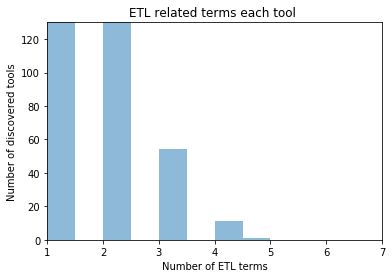

In [34]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([1, 7])
plt.ylim([0, 130])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

### ETL related annotations count. Free text queries

In [35]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_free_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)

                      tool  ETL annotations count
1257                osirix                      4
1034             fairifier                      4
880                clobnet                      4
1217         query tabular                      3
1085              museqbox                      3
...                    ...                    ...
2370                ribopy                      0
2368               ecogene                      0
838              missequel                      0
2366  measurementerror.cor                      0
670                  dbvar                      0

[3922 rows x 2 columns]


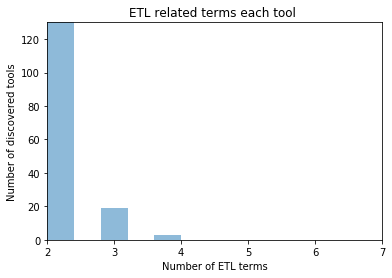

In [36]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([2, 7])
plt.ylim([0, 130])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

### ETL related annotations count. Free text and EDAM queries 

In [66]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_free_ETL.values():
        if tool in list(l):
            matches += 1
    for l in tools_per_term_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)
max(ETL_annot_count_df['ETL annotations count'])

                                           tool  ETL annotations count
3587                                   martview                      6
1217                              query tabular                      6
1034                                  fairifier                      6
1257                                     osirix                      5
1089                                   disqover                      5
...                                         ...                    ...
1510                                     imageo                      1
1511                                      svmtm                      1
1512                          frogs_biom_to_tsv                      1
1513  ergo genome analysis and discovery system                      1
3921                                   pperturb                      1

[3922 rows x 2 columns]


6

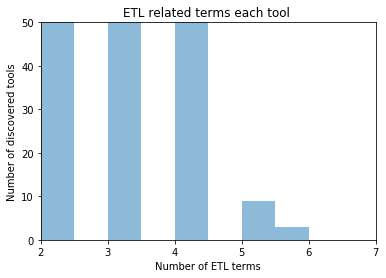

In [38]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([2, 7])
plt.ylim([0, 50])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

In [39]:
# Save ETL ranked by count results
ETL_annot_count_df.to_csv("outputs/20210122_ETL_ranked_by_counts.csv")

### ETL rank tools using keywords and weight

In [40]:
# load weigh file

def read_ranking(filename):
    ranked_keywords = pd.read_csv(filename)
    
    ranked_keywords['weight'] = ranked_keywords["weight"].apply(lambda x: float(x.strip('%'))*0.01)
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    ranked_keywords = ranked_keywords.applymap(trim_strings)
    return ranked_keywords

def get_description(tool_name):
    url_temp ='https://bio.tools/api/tool/?name="{name}"&format=json'
    ep = 'https://bio.tools/api/tool/?name="'
    query = url_temp.format(name=tool_name)
    try:
        response = requests.get(query)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
    finally:
        response = json.loads(response.text)
        descriptions = [l['description'] for l in response['list']]
    
    return(descriptions)

# Todo revise and count weight

In [41]:
ETL_ranked = "keywords/ETL_EDAM_ranked.csv"
ranked_keys = read_ranking(ETL_ranked)
print(ranked_keys)

                                     keyword  weight
0                                 data store     1.0
1                              data warehous     1.0
2                                  data lake     1.0
3                            aggregated data     0.5
4                                        ETL     1.0
5                                     ingest     0.5
6                                    retriev     0.5
7                            Cloud migration     0.5
8                       Database replication     0.5
9                                   dataflow     0.5
10                                  integrat     1.0
11                                   extract     1.0
12                                 transform     1.0
13                             data cleaning     1.0
14                                   loading     0.5
15                                   validat     1.0
16                                     query     0.5
17                                provenance  

In [149]:
def rank_tools(tool_list,ranked_keywords):
    matches_tools = {}
    for tool in list(tool_list):
        matches = 0
        row = []
        for l in ranked_keywords['keyword']:
            if tool in list(l):
                matches += 1
        for l in tools_per_term_ETL.values():
            if tool in list(l):
                matches += 1
        matches_tools[tool] = matches
        
def rank_tools(tool_list,ranked_keywords,tools_per_term, tools_per_term_free, joint_results, max_matches):
    w_matches_tools = []
    keywords = ranked_keywords['keyword'].tolist()
    print(keywords)
    for tool in list(tool_list):
        w_matches = 0
        matches = 0
        for k,l in tools_per_term_free.items():
            if tool in list(l):
                if k not in keywords:
                    print('%s not in keywords list. Assigning score of 0.7'%k)
                    w_matches += 0.7
                    matches += 1
                else:
                    w_matches += ranked_keywords.loc[ranked_keywords['keyword'] == k, 'weight'].item()
                    matches += 1
                    
        for k,l in tools_per_term.items():
            if tool in list(l):
                if k not in keywords:
                    print('%s not in keywords list. Assigning score of 0.7'%k)
                    w_matches += 0.7
                    matches += 1
                else:
                    w_matches += ranked_keywords.loc[ranked_keywords['keyword'] == k, 'weight'].item()
                    matches += 1

        tool_description = joint_results.loc[joint_results['name'] == tool, 'description'].iloc[0]
        links = joint_results.loc[joint_results['name'] == tool, 'links'].tolist()[0]
        if links:
            tool_url = links[0].get('url')
        else:
            tool_url = None
            
        biotools_url = 'https://bio.tools/%s'%tool
        score = w_matches/max_matches
        row = [tool, "{:.3f}".format(score), tool_description, tool_url, biotools_url]
        w_matches_tools.append(row)
    
    weight_ranked=pd.DataFrame(w_matches_tools, columns = ['Tool', 'Score', 'Description', 'URL', 'bio.tools URL']).sort_values('Score', ascending=False)
    return(weight_ranked)
    

In [150]:
max_matches = max(ETL_annot_count_df['ETL annotations count'])
df_ranked_tools = rank_tools(all_ETL_tools,ranked_keys, tools_per_term_ETL, tools_per_term_free_ETL, ETL_joint_results, max_matches)

['data store', 'data warehous', 'data lake', 'aggregated data', 'ETL', 'ingest', 'retriev', 'Cloud migration', 'Database replication', 'dataflow', 'integrat', 'extract', 'transform', 'data cleaning', 'loading', 'validat', 'query', 'provenance', 'Data quality', 'deposit', 'format', 'data unification', 'workflow', 'transfer', 'Data integration and warehousing', 'data governance', 'Data identity and mapping', 'Data submission, annotation and curation', 'Database management', 'workflows', 'Data quality management', 'parsing', 'deposition', 'aggregation', 'formatting', 'Query and retrieval', 'Information extraction', 'Format validation']


In [151]:
df_ranked_tools.to_csv('outputs/ETL/ranked_tools.csv', index=False)

## Case 2: Ontology tools discovery

In this case, the file of zooma results is `ontology_annotation_EDAM_curated_csv.csv`.

### Step 1: parsing zooma results

In [122]:
terms_file='keywords/ontology_annotation_EDAM_curated.csv'
ontology_edam_terms, terms_label_ontology, ontology_free_terms = parse_zooma_results(terms_file)
print(ontology_edam_terms)
print(terms_label_ontology)
print(ontology_free_terms)

['operation_0226', 'operation_3778', 'topic_0089', 'operation_3280']
{'operation_0226': 'Annotation', 'operation_3778': 'Text annotation', 'topic_0089': 'ontology and terminology', 'operation_3280': 'Named-entity and concept recognition'}
['Ontology annotation', 'semantic annotation', 'Text mining', 'Entity tagging', 'Entity recognition', 'Query expansion', 'Query expansion', 'Knowledge graph', 'Knowledge graph', 'Module extraction (eg slims)', 'Module extraction (eg slims)', 'Free text mapping', 'NLP']


### Step 2: doing the query. 

#### Step 2.1: EDAM queries

In [123]:
ontology_results_general, ontology_results_detailed  = query_for_terms(ontology_edam_terms, True)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_0226"&page=14&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_3778"&page=6&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_0089"&page=32&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_3280"&page=7&format=json
Requests finished.


In [124]:
path_output_ontology = "outputs/ontology"
Path(path_output_ontology).mkdir(parents=True, exist_ok=True)
save_results(ontology_results_general, terms_label_ontology, path_output_ontology)

#### Step 2.2: free text queries

In [125]:
ontology_free_results_general, ontology_free_results_detailed  = query_for_terms(ontology_free_terms, False)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Ontology annotation"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="semantic annotation"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Text mining"&page=6&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Entity tagging"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Entity recognition"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Query expansion"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Knowledge graph"&page=1&format=json
Requests finished.
Starting makin

In [127]:
frames = []
for term in ontology_results_detailed:
    frames.append(ontology_results_detailed[term])
for term in ontology_free_results_detailed:
    frames.append(ontology_free_results_detailed[term])
ontology_joint_results = pd.concat(frames)

len(ontology_joint_results.drop_duplicates(subset=['name']))


539

In [128]:
ontology_joint_results = ontology_joint_results.drop_duplicates(subset=['name'])

#### Total number of terms

In [40]:
len(ontology_results_general.keys())

4

In [41]:
len(ontology_free_results_general.keys())

10

#### Tools per term

In [42]:
count_tools_per_term(ontology_results_general)

{'operation_0226': 131,
 'operation_3280': 63,
 'operation_3778': 47,
 'topic_0089': 283}

In [43]:
count_tools_per_term(ontology_free_results_general)

{'Entity recognition': 9,
 'Entity tagging': 1,
 'Free text mapping': 0,
 'Knowledge graph': 10,
 'Module extraction (eg slims)': 0,
 'NLP': 7,
 'Ontology annotation': 10,
 'Query expansion': 0,
 'Text mining': 51,
 'semantic annotation': 7}

#### Lists of tool names per term
This is handy for validation

In [152]:
tools_per_term_ontology = tools_per_term(ontology_results_general)
tools_per_term_ontology = {terms_label_ontology[term]:tools_per_term_ontology[term] for term in tools_per_term_ontology.keys()}

In [153]:
tools_per_term_free_ontology = tools_per_term(ontology_free_results_general)
tools_per_term_free_ontology = {term:tools_per_term_free_ontology[term] for term in tools_per_term_free_ontology.keys()}

In [154]:
save_lists_tools(tools_per_term_ontology, path_output_ontology, True)

In [155]:
save_lists_tools(tools_per_term_free_ontology, path_output_ontology, False)

#### Merged tools lists
All tools discovered merged in a single set

In [156]:
all_ontology_tools = merge_tools_lists([ontology_results_general,  ontology_free_results_general])
all_ontology_tools

{'a4preproc',
 'aber-owl',
 'acela',
 'aceparser',
 'ads',
 'adverse drug event presentation and tracking (adept)',
 'agrigo',
 'ahtpdb',
 'aiso',
 'ajia',
 'allenricher',
 'alliance genome resources',
 'aloha',
 'alvisir',
 'amigo 2',
 'amtdb',
 'anabel',
 'anddigest',
 'annot',
 'annotationfilter',
 'ape',
 'arachnoserver',
 'argminer',
 'aristo',
 'arpir',
 'asa-ps',
 'aspgd',
 'association viewer',
 'avian immunome db',
 'bagel2',
 'becas',
 'beere',
 'bel commons',
 'bel2abm',
 'belief',
 'bgeedb',
 'bibliome variant database',
 'bio-answerfinder',
 'bio.tools',
 'bio2bel',
 'biobert',
 'biocaddie',
 'biocatalogue',
 'bioconceptvec',
 'biocontext',
 'biocpkgtools',
 'bioecs',
 'bioexcel genome sequence quality control workflow',
 'biogateway',
 'biojs-vis-gprofiler',
 'biokc',
 'biolabeler',
 'biolit',
 'biomoby',
 'biomodels database',
 'bionda - biomarker database',
 'bioner',
 'bionet-mining',
 'biont',
 'bioportal',
 'bior',
 'bipom',
 'bittersweet',
 'biwalklda',
 'blood expo

In [135]:
len(all_ontology_tools)

539

### Ontology related annotations count

In [157]:
matches_tools = {}
for tool in list(all_ontology_tools):
    matches = 0
    for l in tools_per_term_ontology.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ontology_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ontology annotations count']).sort_values('ontology annotations count', ascending=False)
print(ontology_annot_count_df)

                      tool  ontology annotations count
4                    acela                           3
43                   craft                           3
281                ppr-ssm                           3
408                    pmo                           2
51   dictybase update 2011                           2
..                     ...                         ...
243             protmapper                           0
503                mechspy                           0
352                robokop                           0
216                e3miner                           0
0                  cadgene                           0

[539 rows x 2 columns]


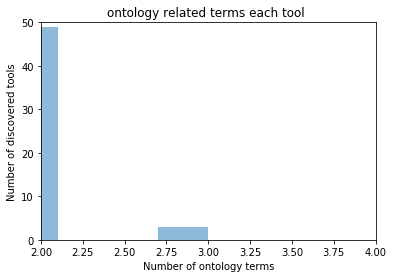

In [137]:
plt.hist(ontology_annot_count_df['ontology annotations count'],alpha=0.5)
plt.xlim([2, 4])
plt.ylim([0, 50])
plt.title('ontology related terms each tool ')
plt.xlabel('Number of ontology terms')
plt.ylabel('Number of discovered tools')
plt.show()

plt.hist(ontology_annot_count_df['ontology annotations count'],alpha=0.5)
plt.xlim([2, 4])
plt.ylim([0, 50])
plt.title('ontology related terms each tool ')
plt.xlabel('Number of ontology terms')
plt.ylabel('Number of discovered tools')
plt.show()

### Ontology rank tools using keywords and weight

In [164]:
ontology_ranked = "keywords/ontology_annotation_EDAM_ranked.csv"
ontology_ranked_keys = read_ranking(ontology_ranked)
print(ontology_ranked_keys)

                                 keyword  weight
0                    Ontology annotation    1.00
1                    semantic annotation    0.80
2                            Text mining    0.50
3                        Text annotation    0.50
4                         Entity tagging    0.50
5                     Entity recognition    0.75
6   Named-entity and concept recognition    0.75
7               ontology and terminology    1.00
8                        Query expansion    0.75
9                      Module extraction    0.75
10                     Free text mapping    1.00
11                       Text Annotation    1.00
12                            Annotation    0.50
13                      Ontology mapping    1.00
14                    Ontology alignment    1.00
15                          Term mapping    1.00
16                                   NLP    0.50


In [165]:
max_matches = max(ontology_annot_count_df['ontology annotations count'])
df_ranked_ontology_tools = rank_tools(all_ontology_tools,ontology_ranked_keys, tools_per_term_ontology, tools_per_term_free_ontology, ontology_joint_results, max_matches)

['Ontology annotation', 'semantic annotation', 'Text mining', 'Text annotation', 'Entity tagging', 'Entity recognition', 'Named-entity and concept recognition', 'ontology and terminology', 'Query expansion', 'Module extraction', 'Free text mapping', 'Text Annotation', 'Annotation', 'Ontology mapping', 'Ontology alignment', 'Term mapping', 'NLP']
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7
Knowledge graph not in keywords list. Assigning score of 0.7


In [166]:
df_ranked_ontology_tools.to_csv('outputs/ontology/ranked_tools.csv', index=False)